## Deep Q-Network (DQN) with Hindsight Experience Replay
---

#### Import the Necessary Packages

In [1]:
import gym, random
import numpy as np
from collections import namedtuple, deque
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#### Set Configuration

In [2]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 4        # how often to update the network
FUTURE_K = 4            # hindsight experience replay

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#### Define DQN Agent and Model

In [ ]:
# her 1            
if HER:
    for k in range(num_HER):
        # sample an experience from G, and set its final state as new target g'
        _, _, _, target_new, _ = episode_experience[np.random.randint(t, num_experience)]
        # Compute s_t||g', s_t+1||g'
        obs_new = np.concatenate([state_t, target_new], axis = -1)
        obs_next_new = np.concatenate([state_next_t, target_new], axis = -1)
        # Compute r'
        if np.sum(np.array(state_next_t) == np.array(target_new)) == obs_size:
            reward_new = 0
        else:
            reward_new = -1
        transition_new = np.reshape(np.array([obs_new, action_t, reward_new, obs_next_new]),[1,4])
        MP.put(transition_new)
                    
# her 2

if hindsight:
    for _ in range(future_k):
        future = random.randint(t, steps_taken)  # index of future time step
        new_goal = episode_trajectory[future].next_state  # take future next_state and set as goal
        new_reward, new_done = env.compute_reward(next_state, new_goal)
        state_, next_state_ = torch.cat((state, new_goal)), torch.cat((next_state, new_goal))
        self.memory.add(state_, action, new_reward, next_state_, new_done)

In [4]:
class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()                      # this change the local net to eval mode
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()                     # this just return the local net back to train mode

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # Get max predicted Q values (for next states) from target model
        target_q_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)    
        """
        # disregard action, get best value! 
        # why so many next states? answer: the qnetwork will return each corresponding next states action, the max will pick from each the           best action
        
        # explanation on detach (https://discuss.pytorch.org/t/detach-no-grad-and-requires-grad/16915/7)
        """
        # Compute Q targets for current states 
        target_q = rewards+(gamma*target_q_next*(1-dones))
                            
        # Get expected Q values from local model
        expected_q = self.qnetwork_local(states).gather(1, actions)
        """
        this uses gather instead of detach like target since it only give a s*** to action taken
        # explanation on gather (https://stackoverflow.com/questions/50999977/what-does-the-gather-function-do-in-pytorch-in-layman-terms)
        """
        # Compute loss
        loss = F.mse_loss(expected_q, target_q)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
                            
        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [5]:
class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=64, fc2_units=64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

#### Instantiate the Environment and Agent

In [6]:
env = gym.make('LunarLander-v2')
env.seed(0)
print('State shape: ', env.observation_space.shape)
print('Number of actions: ', env.action_space.n)

agent = Agent(state_size=8, action_size=4, seed=0)

State shape:  (8,)
Number of actions:  4


#### Instantiate the Environment and Agent

Run the code cell below to train the agent from scratch.  You are welcome to amend the supplied values of the parameters in the function, to try to see if you can get better performance!

In [ ]:
class Episode_experience():
    def __init__(self):
        self.memory = []
        
    def add(self, state, action, reward, next_state, done, goal):
        self.memory += [(state, action, reward, next_state, done, goal)]
        
    def clear(self):
        self.memory = []

In [ ]:
K =4

In [2]:
import numpy as np
np.array_equal([255,255,255],[255,255,255])

True

In [7]:
def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            
            if hindsight:
                ep_experience.add(state, action, reward, next_state, done, goal)

            state = next_state
            score += reward
            if done:
                break 
                
        if hindsight: 
            # The strategy can be changed here
            # goal = state # HER, with substituted goal=final_state
            for t in range(len(ep_experience.memory)):
                for k in range(K):
                    future = np.random.randint(t, len(ep_experience.memory))
                    goal = ep_experience.memory[future][3] # next_state of future
                    state,action,reward,next_state,_,_ = ep_experience.memory[t]
                    done = np.array_equal(next_state, goal)
                    agent.step(state, action, reward, next_state, done)
                    ep_experience_her.add(state, action, reward, next_state, done)
                
                
                
                
                
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=200.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

In [8]:
# train the agent
scores = dqn(n_episodes=2000, max_t=1000)

Episode 100	Average Score: -191.75
Episode 200	Average Score: -138.21
Episode 300	Average Score: -39.610
Episode 400	Average Score: -23.80
Episode 500	Average Score: 6.5650
Episode 600	Average Score: 24.90
Episode 700	Average Score: 123.95
Episode 800	Average Score: 186.46
Episode 853	Average Score: 200.82
Environment solved in 753 episodes!	Average Score: 200.82


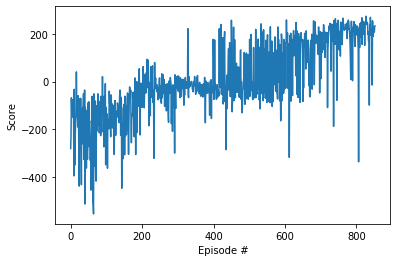

In [9]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

#### Watch a Smart Agent!

In the next code cell, you will load the trained weights from file to watch a smart agent!

In [10]:
# load the weights from file
agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))

for i in range(5):
    state = env.reset()
    for j in range(200):
        action = agent.act(state)
        env.render()
        state, reward, done, _ = env.step(action)
        if done:
            break 
            
env.close()

NoSuchDisplayException: Cannot connect to "None"